In [1]:
import numpy as np 
import pandas as pd
from mlp import mlp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import copy
import datetime

In [2]:
df = pd.read_csv("./dataset/BTC-USD.csv")[-500:]
print "First:", df.Date.values[0]
print "Last:", df.Date.values[-1]
Dates = pd.to_datetime(df.Date)
print df.head(), "\n", len(df)
days = 7
span = 180

First: 2017-02-27
Last: 2018-07-17
            Date         Open         High          Low        Close  \
2417  2017-02-27  1171.579956  1195.819946  1164.270020  1188.829956   
2418  2017-02-28  1188.829956  1208.219971  1175.750000  1189.270020   
2419  2017-03-01  1189.270020  1225.040039  1154.550049  1222.660034   
2420  2017-03-02  1222.660034  1286.979980  1211.959961  1255.469971   
2421  2017-03-03  1255.469971  1291.349976  1250.800049  1283.300049   

        Adj Close    Volume  
2417  1188.829956  42035366  
2418  1189.270020  60371869  
2419  1222.660034  61964760  
2420  1255.469971  98040639  
2421  1283.300049  85876262   
500


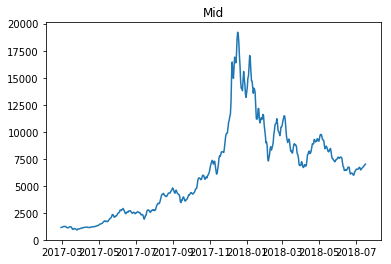

(500,)
(320,)


In [26]:
alll = ((df.Open + df.Close)/2.)#((df.High + df.Low)/2.)
plt.plot(Dates, alll)
plt.title("Mid")
plt.show()
print alll.shape
mid = alll[:-span]
print mid.shape

In [27]:
# return the time series till the day before to the day after
def series_creator(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(y[i + foresee_days])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.hstack((y_n))
a = np.array([1,   2,  3,  4,  5,  6,  7,  8])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18])
print series_creator(a, y, length=2, foresee_days=3)


(array([[1, 2],
       [2, 3],
       [3, 4]]), array([16, 17, 18]))


In [28]:
# return the time series till the day before to the day after
def series_creator_ndays(X, y=None, length=30, foresee_days=0):
    m = X.shape[0]
    X_n = []
    y_n = []
    for i in xrange(length, (m-foresee_days)):
        X_n.append(X[(i-length):i])
        if y is not None:
            y_n.append(y[i-1: i+ foresee_days-1])
    
    if y is None:
        return np.vstack((X_n))
    else:
        return np.vstack((X_n)), np.vstack((y_n))
a = np.array([1,   2,  3,  4,  5,  6,  7,  8])
y = np.array([11, 12, 13, 14, 15, 16, 17, 18])
print series_creator_ndays(a, y, length=3, foresee_days=4)


(array([[1, 2, 3]]), array([[13, 14, 15, 16]]))


## Regressor

In [29]:
reg = linear_model.Ridge(alpha=0.1)

In [30]:
X, y = series_creator(X=mid.values, y=mid.values, length=span, foresee_days=days) 
print X.shape, y.shape
scaler = MinMaxScaler() #just need to be defined here, aS THE Xs are equal
scaler.fit(X)
X_std = scaler.transform(X)
lenx = np.arange(X.shape[0]).reshape(-1,1)
leny = np.arange(y.shape[0]).reshape(-1,1)
print lenx.shape, leny.shape
X_std = np.hstack((lenx, X_std))
y = np.hstack((leny, y.reshape(-1,1)))
print X_std.shape, y.shape

(133, 180) (133,)
(133, 1) (133, 1)
(133, 181) (133, 2)


In [31]:
X_train_std, X_a, y_train, y_a = train_test_split(X_std, y, test_size=0.30, random_state=42)
X_test_std, X_validation_std, y_test, y_validation = train_test_split(X_a, y_a, test_size=0.5, random_state=42)

X_train_std = X_train_std[np.argsort(X_train_std[:, 0]), 1:]
X_validation_std = X_validation_std[np.argsort(X_validation_std[:, 0]), 1:]
X_test_std = X_test_std[np.argsort(X_test_std[:, 0]), 1:]

y_train = y_train[np.argsort(y_train[:,0 ]), 1]
y_validation = y_validation[np.argsort(y_validation[:,0 ]), 1]
y_test =  y_test[np.argsort(y_test[:,0 ]), 1]

print X_train_std.shape, X_validation_std.shape
print y_train.shape, y_validation.shape
generic_x = np.arange(len(y_test))

(93, 180) (20, 180)
(93,) (20,)


In [32]:
reg.fit(X_train_std, y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

final test score: 0.996
MSE: 51005.86


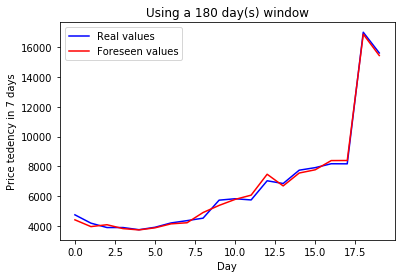

Pearson coef: 0.9980


In [33]:
pred = reg.predict(X_test_std)
print "final test score: %.3f"%reg.score(X_test_std, y_test)
print"MSE: %.2f"%mean_squared_error(y_test, pred)
plt.plot(y_test, c='b', label="Real values")
plt.plot(pred, c='r', label="Foreseen values")
plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()
print "Pearson coef: %.4f"%np.corrcoef(pred, y_test)[0,1] 

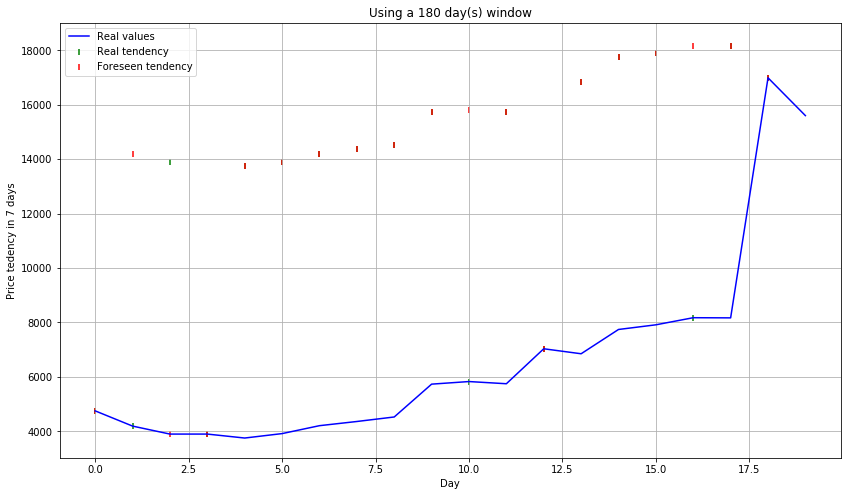

final ac: 99.60%
Delta tendency accuracy: 84.21%


In [34]:
adj=10000
y_diff = y_test[1:] - y_test[:-1]
y_bin = np.where(1, y_diff>0, 0)
my = y_test[:-1] + adj*y_bin

pred_diff =  pred[1:] - pred[:-1]
pred_bin = np.where(1, pred_diff>0, 0)

my2 = y_test[:-1] + adj*pred_bin
plt.figure(figsize = (14,8))
plt.plot(y_test, c='b', label="Real values")


plt.scatter(generic_x[:-1], my, c='g',marker="|", label="Real tendency")
plt.scatter(generic_x[:-1], my2, c='r',marker="|", label="Foreseen tendency")
plt.grid()

plt.title("Using a %s day(s) window"%span)
plt.xlabel("Day")
plt.ylabel("Price tedency in %s days"%days)
plt.legend(loc='best')
plt.show()

print "final ac: %.2f%%"%(100*reg.score(X_test_std, y_test))
c_diff = pred[1:] - y_test[:-1]
c_bin = np.where(1, c_diff>0, 0)
trend = pred_bin.shape[0]-np.count_nonzero(c_bin-y_bin)

print "Delta tendency accuracy: %.2f%%"%(float(trend)/pred_bin.shape[0] *100)

                         

## Making N-days prediction

In [35]:
X3, y3 = series_creator_ndays(X=mid.values, y=mid.values, length=span, foresee_days=days) 
print X3.shape, y3.shape
X_std3 = scaler.transform(X)

lenx3 = np.arange(X3.shape[0]).reshape(-1,1)
leny3 = np.arange(y3.shape[0]).reshape(-1,1)
print lenx3.shape, leny3.shape
X_std3 = np.hstack((lenx3, X_std3))
y3 = np.hstack((leny3, y3))
print X_std3.shape, y3.shape

(133, 180) (133, 7)
(133, 1) (133, 1)
(133, 181) (133, 8)


In [36]:
X_train_std3, X_a3, y_train3, y_a3 = train_test_split(X_std3, y3, test_size=0.30, random_state=42)
X_test_std3, X_validation_std3, y_test3, y_validation3 = train_test_split(X_a3, y_a3, test_size=0.5, random_state=42)

X_train_std3 = X_train_std3[np.argsort(X_train_std3[:, 0]), 1:]
X_validation_std3 = X_validation_std3[np.argsort(X_validation_std3[:, 0]), 1:]
X_test_std3 = X_test_std3[np.argsort(X_test_std3[:, 0]), 1:]

y_train3 = y_train3[np.argsort(y_train3[:,0 ]), 1:]
y_validation3 = y_validation3[np.argsort(y_validation3[:,0 ]), 1:]
y_test3 =  y_test3[np.argsort(y_test3[:,0 ]), 1:]

print X_train_std3.shape, X_validation_std3.shape
print y_train3.shape, y_validation3.shape
generic_x = np.arange(len(y_test3))

(93, 180) (20, 180)
(93, 7) (20, 7)


In [37]:
class mpred():
    def __init__(self):
        self.reg =  linear_model.Ridge(alpha=0.1) 
        self.all_predictors = []
    
    def fit(self, X, y):
        for i in xrange(y.shape[1]):
            self.reg.fit(X, y[:, i])
            self.all_predictors.append(copy.copy(self.reg))
            print "next-->"
        print "All trained!"
    def score(self,X, y):
        sc = []
        for i,j in zip(self.all_predictors, xrange(len(self.all_predictors))):
            sc.append(i.score(X, y[:, j]))
        return sc
    
    def predict(self, X):
        pred = []
        for i,j in zip(self.all_predictors, xrange(len(self.all_predictors))):
            pred.append(i.predict(X))
        return np.vstack(pred).T

reg1 =  mpred()
reg1.fit(X_train_std3, y_train3)


next-->
next-->
next-->
next-->
next-->
next-->
next-->
All trained!


In [38]:
#sees the tendency of deltas and scores it
def tendence_score(y_real, y_pred):
    pred_diff = y_pred[1:, :] - y_pred[:-1, :]
    real_diff = y_real[1:, :] - y_real[:-1, :]
    
    real_bin = np.where(1, real_diff>0, 0)
    pred_bin = np.where(1, pred_diff>0, 0)

    bn =  (y_real.shape[0] - np.count_nonzero(pred_bin - real_bin, axis=0))/float(y_real.shape[0])
    return bn


def tendence_score2(y_real, y_pred):
    pred_diff = (y_pred[:, 1:].T - y_pred[:, 0]).T
    real_diff = (y_real[:, 1:].T - y_real[:, 0]).T
    
    real_bin = np.where(1, real_diff>0, 0)
    pred_bin = np.where(1, pred_diff>0, 0)
    
    bn =  (y_real.shape[0] - np.count_nonzero(pred_bin - real_bin, axis=0))/float(y_real.shape[0])
    return bn


def end_tendence_score(y_real, y_pred):
    
    pred_diff = y_pred[1:, -1] - y_pred[:-1, 0]
    real_diff = y_real[1:, -1] - y_real[:-1, 0]
    
    real_bin = np.where(1, real_diff>0, 0)
    pred_bin = np.where(1, pred_diff>0, 0)

    bn =  (y_real.shape[0] - np.count_nonzero(pred_bin - real_bin, axis=0))/float(y_real.shape[0])
    return bn

def delta_tendence(y):
    delta =  y[:, 1:] - y[:, :-1]
    return np.where(1, delta>0, 0)
    

In [39]:
print "final test %s \n"%reg1.score(X_test_std3, y_test3)
td =  tendence_score(y_test3, reg1.predict(X_test_std3))
td2 =  tendence_score2(y_test3, reg1.predict(X_test_std3))
pred1 = reg1.predict(X_test_std3)
print"Tendence score %s | mean tendence score %.3f"%(td, td.mean()), "\n"

print"Tendence score2 %s | mean tendence score %.3f"%(td2, td2.mean()), "\n"

etd =  end_tendence_score(y_test3, reg1.predict(X_test_std3))
print"tendence to the end %.3f"%etd, "\n"

me = mean_squared_error(y_test3, pred1)
print"MSE %.2f"%(me)

final test [0.9941329288865539, 0.9952714984371184, 0.9917230297559394, 0.9922186823441234, 0.9948330338769035, 0.9924548322605318, 0.9912511297830042] 

Tendence score [0.8  0.95 0.85 0.8  0.85 0.9  0.75] | mean tendence score 0.843 

Tendence score2 [0.55 0.55 0.8  0.75 0.85 0.85] | mean tendence score 0.725 

tendence to the end 0.800 

MSE 90863.01


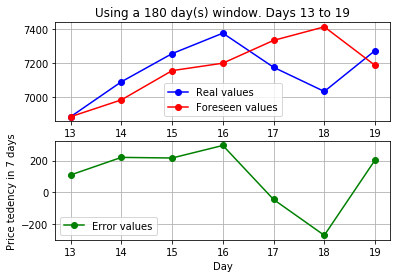

Absolute error  for 7 day(s):1340.812


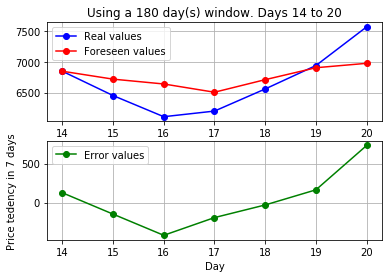

Absolute error  for 7 day(s):1776.593


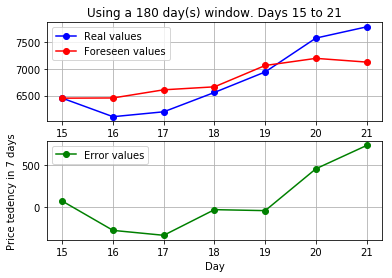

Absolute error  for 7 day(s):1945.281


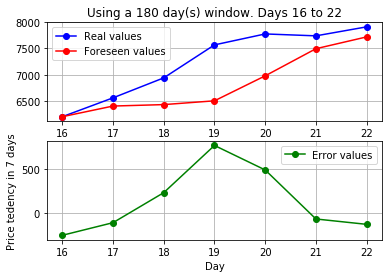

Absolute error  for 7 day(s):2107.143


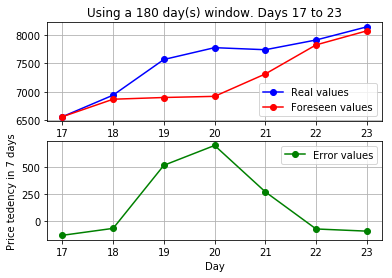

Absolute error  for 7 day(s):1895.622


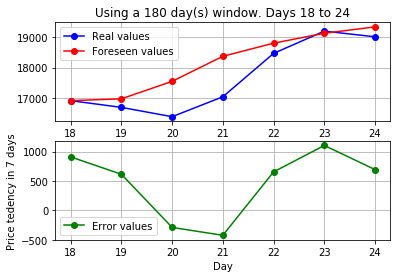

Absolute error  for 7 day(s):4447.072


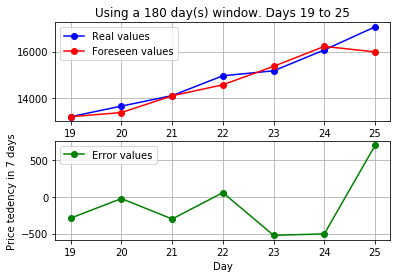

Absolute error  for 7 day(s):2456.634


In [40]:
for i in xrange((y_test3.shape[0] - days), y_test3.shape[0]):
    mc = y_test3[i,0]/pred1[i, 0]
    myX = range(i, (i+days)) 
    plt.subplot(211)
    plt.title("Using a %s day(s) window. Days %s to %s"%(span, i, i+days-1))
    plt.plot(myX, y_test3[i,:], "-o", c='b', label="Real values")
    plt.plot(myX, pred1[i,:] * mc ,"-o",  c='r', label="Foreseen values")
    plt.legend(loc='best')
    plt.grid()
    plt.subplot(212)
    plt.plot(myX,(y_test3[i,:]- pred1[i,:] )* mc ,"-o",  c='g', label="Error values")
    plt.grid()
    plt.xlabel("Day")
    plt.ylabel("Price tedency in %s days"%days)
    plt.legend(loc='best')
    plt.show()
    print "Absolute error  for %s day(s):%.3f"%( days,np.abs(y_test3[i,:]- pred1[i,:]).sum())

day 1 ac: 99.41%
day 2 ac: 99.53%
day 3 ac: 99.17%
day 4 ac: 99.22%
day 5 ac: 99.48%
day 6 ac: 99.25%
day 7 ac: 99.13%


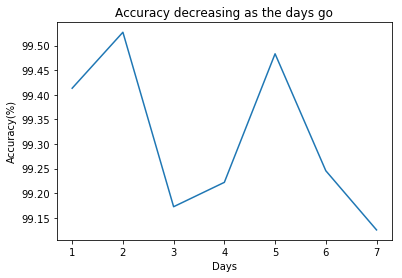

Pearson coef: 


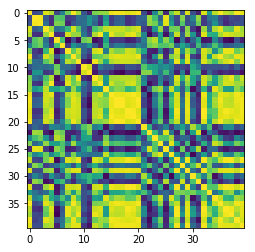

0, 0.99742
1, 0.99794
2, 0.99607
3, 0.99645
4, 0.99757
5, 0.99676
6, 0.99767


In [41]:
ac = []
xl = range(1, days+1)
for i in xrange(days):
    ac.append(100*r2_score(y_test3[:, i], pred1[:,i]))
    print "day %s ac: %.2f%%"%(i+1, ac[i] )
plt.plot(xl, ac)
plt.title("Accuracy decreasing as the days go")
plt.xlabel("Days")
plt.ylabel("Accuracy(%)")
plt.show()

print "Pearson coef: "
plt.imshow(np.corrcoef(pred1, y_test3, ))
plt.show()
for i in xrange(days):
    print "%s, %.5f"%(i, np.corrcoef(pred1[:, i], y_test3[:, i])[0,1])

## Testing my results

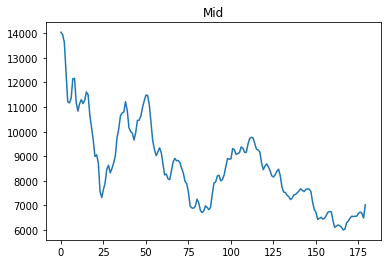

(1, 180)


In [42]:
mid_ = alll[-span:].values.reshape(1,-1)

plt.plot(mid_[0,:])
plt.title("Mid")
plt.show()
print mid_.shape

In [44]:
Xf_std = scaler.transform(mid_)
print Xf_std.shape
print df.Date.values[-1]
ct = 25050/mid_[0,-1]#brl cte corrected by the walltime Inc. price at the time, 22:00, 2018-07-10
print "Rate(usd to brl)", ct

(1, 180)
2018-07-17
Rate(usd to brl) 3.565265348965468


#### For n-days predictions 

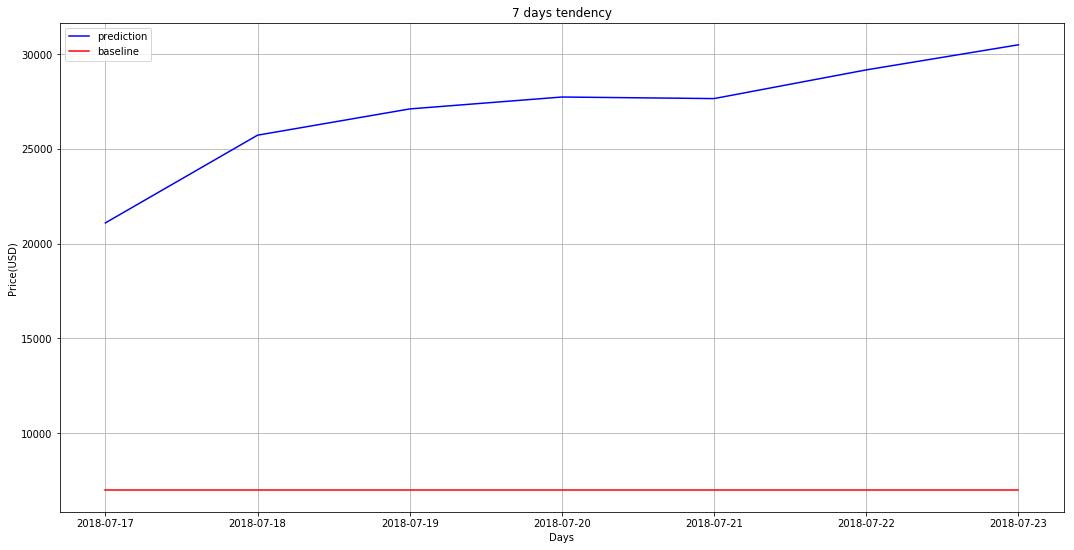

Prediction for 7 days from now: 30489.05
Delta from today to then: 23462.92


In [45]:
final_prof = reg1.predict(Xf_std)
baseline = np.ones(final_prof.shape[1]) * mid_[0,-1]
datelist = pd.date_range(datetime.datetime.strptime(df.Date.values[-1], "%Y-%m-%d"), periods=days).values
#datelist = df.Date.values[-days:]
plt.figure(figsize = (18,9))
plt.plot(datelist, final_prof[0,:], c="b", label="prediction")
plt.plot(datelist, baseline, c="r", label="baseline")
plt.title("%s days tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(USD)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Prediction for %s days from now: %.2f"%(days, final_prof[0,-1])
print "Delta from today to then: %.2f"%(final_prof[0, -1] - mid_[0,-1])

In BRL


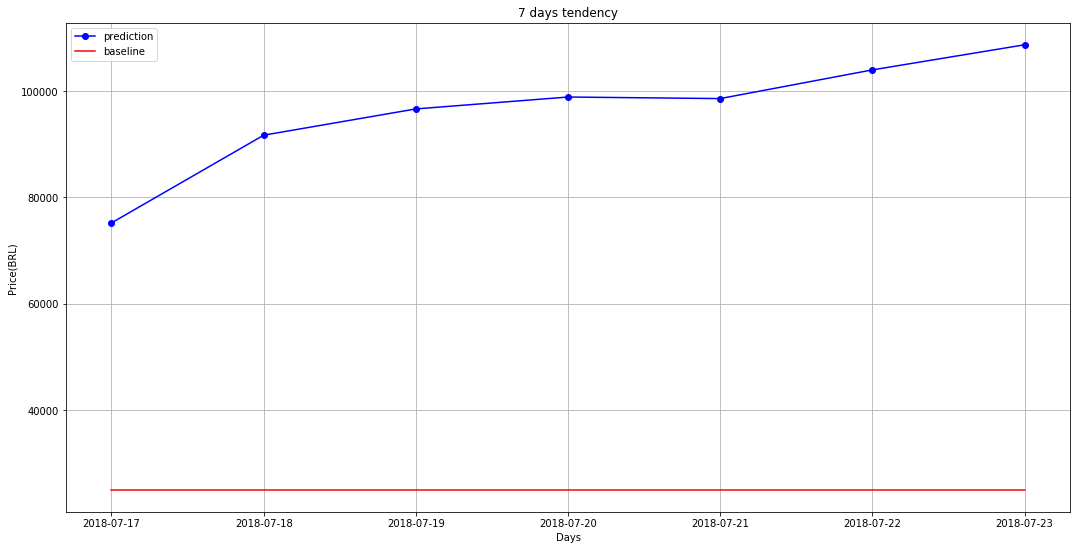

Prediction for 7 days from now: BRL 108701.54
Delta from today to then: BRL 83651.54


In [46]:
print "In BRL"
final_profb = final_prof * ct
baselineb = baseline * ct
plt.figure(figsize = (18,9))
plt.plot(datelist, final_profb[0,:],'-o', c="b", label="prediction")
plt.plot(datelist, baselineb, c="r", label="baseline")
plt.title("%s days tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(BRL)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Prediction for %s days from now: BRL %.2f"%(days, final_profb[0,-1])
print "Delta from today to then: BRL %.2f"%( final_profb[0, -1] - (mid_[0,-1]*ct) )


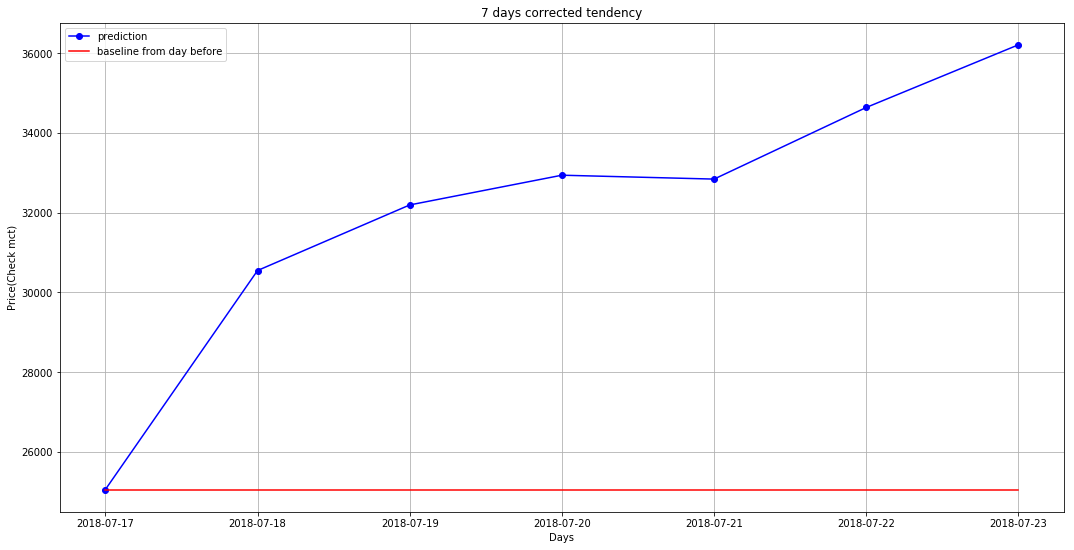

Corrected prediction for 7 days from now: 36208.68 (check mct)
Corrected delta from today to then: 11158.68 (check mct)


In [47]:
# Correcting the values to the tendency (Matching the predicted to the real to see the 'real' tendency only)

mct = ct # change to 1 for no correction
rea_t_cte = mid_[0,-1]/final_prof[0,0]

plt.figure(figsize = (18,9))
plt.plot(datelist, final_prof[0,:]*rea_t_cte * mct ,'-o', c="b", label="prediction")
plt.plot(datelist, baseline * mct, c="r", label="baseline from day before")
plt.title("%s days corrected tendency"%days)
plt.xlabel("Days")
plt.ylabel("Price(Check mct)")
plt.legend(loc="best")
plt.grid()
plt.show()
print "Corrected prediction for %s days from now: %.2f (check mct)"%(days, final_prof[0,-1]* rea_t_cte  * mct)
print "Corrected delta from today to then: %.2f (check mct)"%((final_prof[0, -1]*rea_t_cte - mid_[0,-1])*mct)


#### One day prediction 

In [48]:
print "Value today: USD %.2f"% mid_[0,-1]
print "Prediction for %s  days from now (now: %s): USD %.2f"%(days, df.Date.values[-1], reg.predict(Xf_std)[0])
print "Delta from today to then: USD %.2f"%(reg.predict(Xf_std)[0] - mid_[0,-1] )


Value today: USD 7026.12
Prediction for 7  days from now (now: 2018-07-17): USD 35542.01
Delta from today to then: USD 28515.89


In [49]:
print "In BRL"
print "Value today: BRL %.2f"%(mid_[0,-1] *ct)
print "Prediction for %s days from now (now: %s): BRL %.2f"%(days, df.Date.values[-1], ct * reg.predict(Xf_std)[0])
print "Delta from today to then: BRL %.2f"%((reg.predict(Xf_std)[0] - mid_[0,-1]) * ct)


In BRL
Value today: BRL 25050.00
Prediction for 7 days from now (now: 2018-07-17): BRL 126716.71
Delta from today to then: BRL 101666.71
